<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импортирование-библиотек" data-toc-modified-id="Импортирование-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импортирование библиотек</a></span></li><li><span><a href="#Выгрузка-данных-из-Clickhouse" data-toc-modified-id="Выгрузка-данных-из-Clickhouse-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выгрузка данных из Clickhouse</a></span></li><li><span><a href="#Исследование-и-обработка-данных-в-python" data-toc-modified-id="Исследование-и-обработка-данных-в-python-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование и обработка данных в python</a></span></li><li><span><a href="#Разделение-на-когорты" data-toc-modified-id="Разделение-на-когорты-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разделение на когорты</a></span><ul class="toc-item"><li><span><a href="#Месяц" data-toc-modified-id="Месяц-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Месяц</a></span></li><li><span><a href="#Неделя" data-toc-modified-id="Неделя-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Неделя</a></span></li></ul></li><li><span><a href="#Retention" data-toc-modified-id="Retention-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Retention</a></span><ul class="toc-item"><li><span><a href="#Месяц" data-toc-modified-id="Месяц-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Месяц</a></span></li><li><span><a href="#Неделя" data-toc-modified-id="Неделя-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Неделя</a></span></li></ul></li><li><span><a href="#ARPU" data-toc-modified-id="ARPU-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ARPU</a></span><ul class="toc-item"><li><span><a href="#Месяц" data-toc-modified-id="Месяц-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Месяц</a></span></li><li><span><a href="#Неделя" data-toc-modified-id="Неделя-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Неделя</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Описание задачи

**Что нужно сделать:**
1. Написать `SQL` запрос для выгрузки данных из `Clickhouse`
2. Дообработать получившиеся данные в `Python`
3. Сделать визуализацию (графики)
    - Когортное `ARPU` (по дням, неделям и месяцам) 
    - Когортный `Retention` (по дням, неделям и месяцам)
4. Проанализировать результаты - что произошло с метриками, есть ли аномалии?
5. Закоммитить `Python` код в свой `github`

**Подключение к Clickhouse:** 

"host": "dev-01.aksimemor.me"  
"port": "9000" (если коннект из питона) "8123" (если через sql editor)  
"database": "default"  
"table": "marvel"  
"user": "thanos"  
"password": "show_me_your_data"

**Описание данных:**  

`user_id` - *UUID* - id игрока  
`installed_at` - *DateTime* - Дата и время установки  
`created_at` - *DateTime* - Дата и время события  
`day` - *Int* - День жизни игрока с момента установки  
`country` - *String* - Страна пользователя в момент совершения события  
`app_version_short` - *String* - Версия мобильного приложения  
`last_time_spent` - *Int* - Продолжительность последней сессии в секундах  
`lifetime_session_count` - *Int* - Общее кол-во сессий игрока к данному событию  
`activity_kind` -  *String*  -  Тип события  
`event_name` -  *String*  -  Название события  
`reporting_revenue` - *Float*  -  Выручка 

## Импортирование библиотек

In [ ]:
!pip3 install clickhouse-driver[lz4]

In [1]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Выгрузка данных из Clickhouse

In [ ]:
client = Client('dev-01.aksimemor.me',
                user='thanos',
                password='show_me_your_data',
                database='default',
                port=9000)

In [ ]:
t, columns = client.execute('SELECT * FROM marvel', with_column_types=True)

In [ ]:
df = pd.DataFrame(t, columns=[tuple[0] for tuple in columns])

Для быстроты работы, данные сохраним в csv:

In [ ]:
df.to_csv('appquantum.csv')

## Исследование и обработка данных в python

In [2]:
df = pd.read_csv('appquantum.csv', parse_dates=['installed_at', 'created_at'])

In [3]:
df.drop(df.columns[0], inplace=True, axis=1)

In [4]:
df.head()

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
0,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 14:40:38,92,us,1.7.4,0,12,event,revenue_all,2.99000
1,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 16:25:38,92,us,1.7.4,0,13,event,revenue_all,6.99000
2,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-28 01:11:46,92,us,1.7.4,0,17,event,revenue_all,6.99000
3,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-31 16:32:22,96,us,1.7.4,0,36,event,revenue_all,9.99000
4,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-15 10:51:03,58,vn,1.6.4,0,57,event,revenue_all,4.68626


Создадим функцию для исследования данных:

In [5]:
def examine_df(df):
    display(df.head(10))
    display(df.info())
    display(df.describe(include='all'))
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.style.format('{:.1f}', subset='Percent')
    
    print(f'Количество пропусков {missing_data}')    
    print(f'Количество дубликатов : {df.duplicated().sum()} или {df.duplicated().sum() / df.shape[0]:.1%}')
    print('_____________________________________________')

In [6]:
examine_df(df)

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
0,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 14:40:38,92,us,1.7.4,0,12,event,revenue_all,2.990000
1,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 16:25:38,92,us,1.7.4,0,13,event,revenue_all,6.990000
2,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-28 01:11:46,92,us,1.7.4,0,17,event,revenue_all,6.990000
3,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-31 16:32:22,96,us,1.7.4,0,36,event,revenue_all,9.990000
4,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-15 10:51:03,58,vn,1.6.4,0,57,event,revenue_all,4.686260
5,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-15 11:06:47,58,vn,1.6.4,0,57,event,revenue_all,4.686260
6,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-19 16:24:17,63,vn,1.6.4,0,59,event,revenue_all,4.676041
7,e8c160bc-9a93-3285-0623-2a2c72264631,2019-12-25 21:57:15,2020-02-18 20:28:31,54,gb,1.6.2,0,16,event,revenue_all,9.089065
8,e8c160bc-9a93-3285-0623-2a2c72264631,2019-12-25 21:57:15,2020-03-25 21:50:13,90,gb,1.7.4,0,27,event,revenue_all,8.233419
9,216e78e2-1c24-a006-0908-f2aefd46da04,2019-12-26 04:05:37,2020-03-15 12:20:21,80,au,1.7.2,0,78,event,revenue_all,1.848119


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16811210 entries, 0 to 16811209
Data columns (total 11 columns):
user_id                   object
installed_at              datetime64[ns]
created_at                datetime64[ns]
day                       int64
country                   object
app_version_short         object
last_time_spent           int64
lifetime_session_count    int64
activity_kind             object
event_name                object
reporting_revenue         float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 1.4+ GB


None

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
count,16811210,16811210,16811210,1.681121e+07,16811114,16811210,1.681121e+07,1.681121e+07,16811210,94241,1.681121e+07
unique,2184337,1895480,7092816,NaN,225,40,NaN,NaN,2,1,NaN
top,112e8e94-3abc-823b-e74c-d18e26b5e72b,2020-04-07 05:57:05,2020-04-23 13:30:13,NaN,us,2.1.0,NaN,NaN,session,revenue_all,NaN
freq,976,977,20,NaN,3781951,6068646,NaN,NaN,16716969,94241,NaN
first,NaN,2019-12-16 08:33:30,2020-01-17 15:48:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-07-01 23:16:03,2020-07-01 23:59:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,7.717689e+00,NaN,NaN,9.397399e+02,2.092520e+01,NaN,NaN,4.991077e-02
std,NaN,NaN,NaN,1.261856e+01,NaN,NaN,2.000869e+03,3.608587e+01,NaN,NaN,8.758815e-01
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,0.000000e+00,NaN,NaN,7.800000e+01,4.000000e+00,NaN,NaN,0.000000e+00


Количество пропусков                            Total    Percent
event_name              16716969  99.439416
country                       96   0.000571
reporting_revenue              0   0.000000
activity_kind                  0   0.000000
lifetime_session_count         0   0.000000
last_time_spent                0   0.000000
app_version_short              0   0.000000
day                            0   0.000000
created_at                     0   0.000000
installed_at                   0   0.000000
user_id                        0   0.000000
Количество дубликатов : 137 или 0.0%
_____________________________________________


Удалим дупликаты, их всего 137:

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
examine_df(df)

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
0,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 14:40:38,92,us,1.7.4,0,12,event,revenue_all,2.990000
1,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 16:25:38,92,us,1.7.4,0,13,event,revenue_all,6.990000
2,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-28 01:11:46,92,us,1.7.4,0,17,event,revenue_all,6.990000
3,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-31 16:32:22,96,us,1.7.4,0,36,event,revenue_all,9.990000
4,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-15 10:51:03,58,vn,1.6.4,0,57,event,revenue_all,4.686260
5,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-15 11:06:47,58,vn,1.6.4,0,57,event,revenue_all,4.686260
6,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-19 16:24:17,63,vn,1.6.4,0,59,event,revenue_all,4.676041
7,e8c160bc-9a93-3285-0623-2a2c72264631,2019-12-25 21:57:15,2020-02-18 20:28:31,54,gb,1.6.2,0,16,event,revenue_all,9.089065
8,e8c160bc-9a93-3285-0623-2a2c72264631,2019-12-25 21:57:15,2020-03-25 21:50:13,90,gb,1.7.4,0,27,event,revenue_all,8.233419
9,216e78e2-1c24-a006-0908-f2aefd46da04,2019-12-26 04:05:37,2020-03-15 12:20:21,80,au,1.7.2,0,78,event,revenue_all,1.848119


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16811073 entries, 0 to 16811209
Data columns (total 11 columns):
user_id                   object
installed_at              datetime64[ns]
created_at                datetime64[ns]
day                       int64
country                   object
app_version_short         object
last_time_spent           int64
lifetime_session_count    int64
activity_kind             object
event_name                object
reporting_revenue         float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 1.5+ GB


None

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
count,16811073,16811073,16811073,1.681107e+07,16810977,16811073,1.681107e+07,1.681107e+07,16811073,94181,1.681107e+07
unique,2184337,1895480,7092816,NaN,225,40,NaN,NaN,2,1,NaN
top,112e8e94-3abc-823b-e74c-d18e26b5e72b,2020-04-07 05:57:05,2020-04-23 13:30:13,NaN,us,2.1.0,NaN,NaN,session,revenue_all,NaN
freq,976,977,20,NaN,3781915,6068592,NaN,NaN,16716892,94181,NaN
first,NaN,2019-12-16 08:33:30,2020-01-17 15:48:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-07-01 23:16:03,2020-07-01 23:59:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,7.717642e+00,NaN,NaN,9.397438e+02,2.092515e+01,NaN,NaN,4.985630e-02
std,NaN,NaN,NaN,1.261833e+01,NaN,NaN,2.000874e+03,3.608562e+01,NaN,NaN,8.749377e-01
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,0.000000e+00,NaN,NaN,7.800000e+01,4.000000e+00,NaN,NaN,0.000000e+00


Количество пропусков                            Total    Percent
event_name              16716892  99.439768
country                       96   0.000571
reporting_revenue              0   0.000000
activity_kind                  0   0.000000
lifetime_session_count         0   0.000000
last_time_spent                0   0.000000
app_version_short              0   0.000000
day                            0   0.000000
created_at                     0   0.000000
installed_at                   0   0.000000
user_id                        0   0.000000
Количество дубликатов : 0 или 0.0%
_____________________________________________


In [9]:
df.event_name.value_counts()

revenue_all    94181
Name: event_name, dtype: int64

In [10]:
df[~df.event_name.isna()]

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
0,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 14:40:38,92,us,1.7.4,0,12,event,revenue_all,2.99000
1,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 16:25:38,92,us,1.7.4,0,13,event,revenue_all,6.99000
2,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-28 01:11:46,92,us,1.7.4,0,17,event,revenue_all,6.99000
3,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-31 16:32:22,96,us,1.7.4,0,36,event,revenue_all,9.99000
4,87c3e898-da20-0d91-04fe-7333bf99e479,2019-12-18 13:18:44,2020-02-15 10:51:03,58,vn,1.6.4,0,57,event,revenue_all,4.68626
...,...,...,...,...,...,...,...,...,...,...,...
16811197,b1c783ac-5fa3-cca3-ffff-f66b83d9a601,2020-05-12 23:12:41,2020-05-13 21:27:19,0,us,2.1.0,0,2,event,revenue_all,1.99000
16811199,b1c783ac-5fa3-cca3-ffff-f66b83d9a601,2020-05-12 23:12:41,2020-05-13 23:39:49,1,us,2.1.0,0,3,event,revenue_all,16.99000
16811200,b1c783ac-5fa3-cca3-ffff-f66b83d9a601,2020-05-12 23:12:41,2020-05-14 00:34:38,1,us,2.1.0,0,3,event,revenue_all,1.99000
16811201,b1c783ac-5fa3-cca3-ffff-f66b83d9a601,2020-05-12 23:12:41,2020-05-14 00:50:04,1,us,2.1.0,0,3,event,revenue_all,7.99000


In [11]:
df.activity_kind.value_counts()

session    16716892
event         94181
Name: activity_kind, dtype: int64

In [12]:
df.groupby('activity_kind')['reporting_revenue'].sum()

activity_kind
event      838137.837783
session         0.000000
Name: reporting_revenue, dtype: float64

In [13]:
df.groupby('event_name')['reporting_revenue'].sum()

event_name
revenue_all    838137.837783
Name: reporting_revenue, dtype: float64

Есть 2 типа activity: event и session. Session не приносит никакой выручки, event имеет event_name revenue_all, event_name для session - пропуски (NaN). 

In [14]:
df[df.country.isna()]['reporting_revenue'].sum()

0.0

Есть пропуски в странах, но их очень мало, и в этих записях нет выручки, так что наверное не сильно важно.

## Разделение на когорты

В условии задачи не сказано, по какому принципу разделять юзеров на когорты. Есть несколько вариантов, например:

- по дате установки  
- по дате первого события
- по стране (в этом признаке есть пропуски, придется удалить строки с пропусками. Хорошо, что их очень мало) 

В этой работе будем разделять на когорты по дате первого события.

In [15]:
df['first_event'] = df.groupby('user_id')['created_at'].transform('min').values

### Месяц

In [16]:
df['cohort_month'] = df['first_event'].dt.to_period('M')

In [17]:
years_diff = df['created_at'].dt.year - df['cohort_month'].dt.year
months_diff = df['created_at'].dt.month - df['cohort_month'].dt.month

In [18]:
df['cohort_month_age'] = years_diff * 12 + months_diff

Количество юзеров для каждой когорты по месяцам:

In [19]:
cohorts_monthly = df.pivot_table(index='cohort_month', columns='cohort_month_age', values='user_id', 
                                 aggfunc=pd.Series.nunique)

Начальное количество юзеров в когортах:

In [21]:
cohort_monthly_sizes = cohorts_monthly.iloc[:,0]

### Неделя

In [22]:
df['cohort_week'] = df['first_event'].dt.week

In [23]:
df['cohort_week_age'] = df['created_at'].dt.week - df['first_event'].dt.week

In [24]:
cohorts_weekly = df.pivot_table(index='cohort_week', columns='cohort_week_age', values='user_id', 
                                 aggfunc=pd.Series.nunique)

In [25]:
cohort_weekly_sizes = cohorts_weekly.iloc[:,0]

## Retention

### Месяц

In [26]:
retention = cohorts_monthly.divide(cohort_monthly_sizes, axis=0).round(3)*100

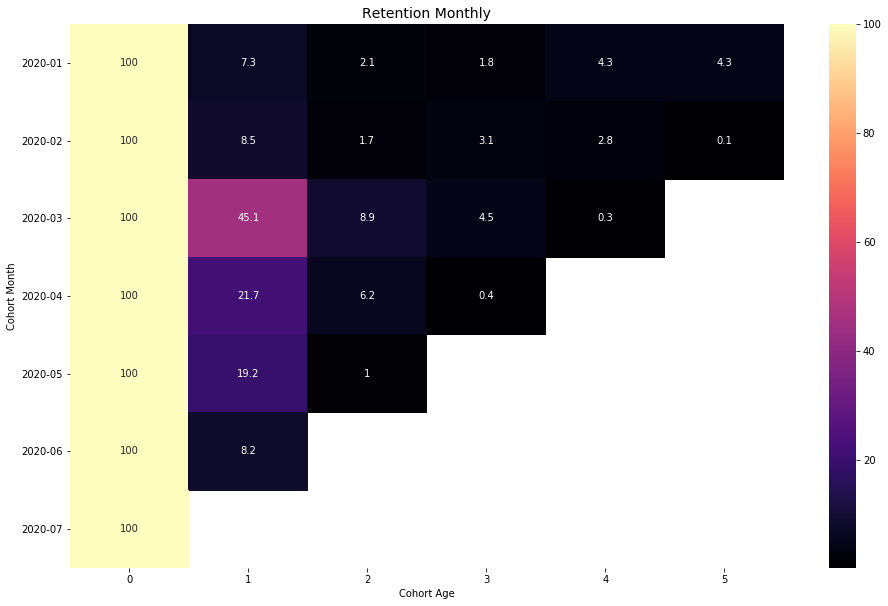

In [27]:
plt.figure(figsize=(16, 10))
plt.title('Retention Monthly', fontsize = 14)
sns.heatmap(retention, annot = True,cmap="magma", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Age')
plt.yticks(rotation='360')
plt.show()

Юзеры, зашедшие в первый раз в игру в марте, вернулись в нее на следующий месяц почти в 5 раз больше, чем остальные когорты. Для следующих когорт количество возвращающихся уменьшается и возвращается к среднему значению.

### Неделя

In [28]:
retention = cohorts_weekly.divide(cohort_weekly_sizes, axis=0).round(3)*100

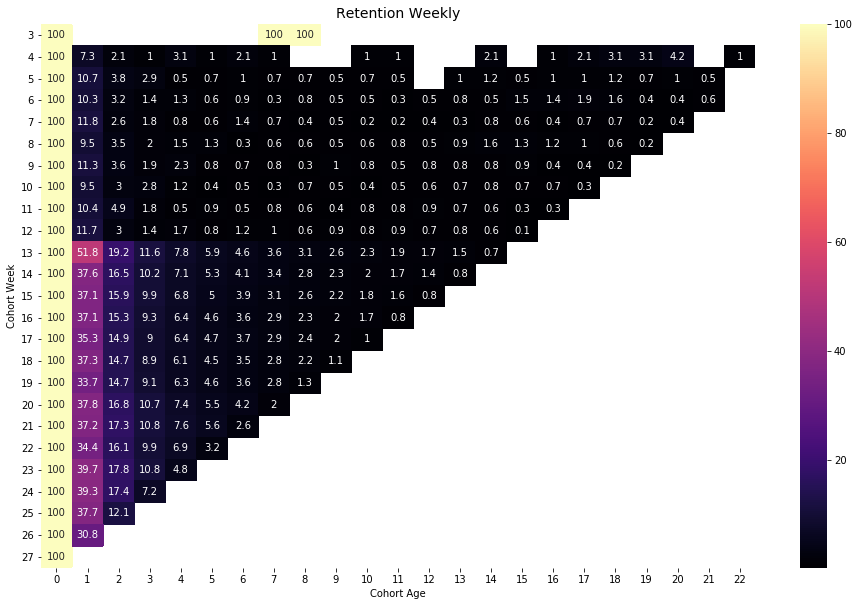

In [29]:
plt.figure(figsize=(16, 10))
plt.title('Retention Weekly', fontsize = 14)
sns.heatmap(retention, annot = True,cmap="magma", fmt='g')
plt.ylabel('Cohort Week')
plt.xlabel('Cohort Age')
plt.yticks(rotation='360')
plt.show()

Повышенный retention для недель, соответствующих месяцам с повышенным retention. Из интересного: когорта 3 недели через 7 недель после первого ивента вся вернулась в игру, а когорты 4-5 недель иногда полностью не заходили в приложение.

## ARPU

### Месяц

In [30]:
revenue_monthly = df.pivot_table(index='cohort_month', columns='cohort_month_age', values='reporting_revenue', aggfunc = 'sum')

In [31]:
arpu_monthly = revenue_monthly.divide(cohort_monthly_sizes, axis=0).round(3)*100

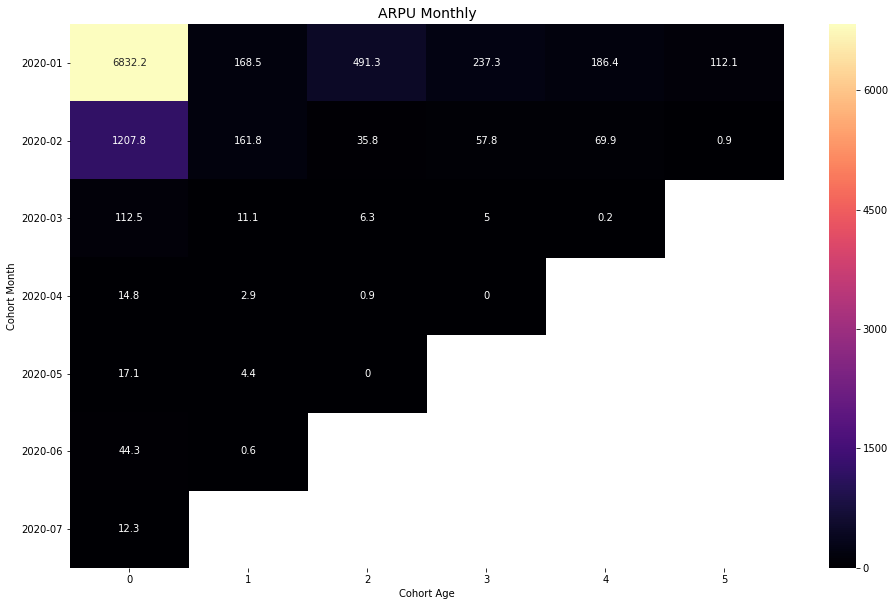

In [32]:
plt.figure(figsize=(16, 10))
plt.title('ARPU Monthly', fontsize = 14)
sns.heatmap(arpu_monthly, annot = True,cmap="magma", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Age')
plt.yticks(rotation='360')
plt.show()

Первые когорты приносят в среднем больше выручки, чем последующие. Когорты с большим retention для второго месяца (когорты 03.2020-05.2020) большую выручку не принесли, играли без покупок.

### Неделя

In [33]:
revenue_weekly = df.pivot_table(index='cohort_week', columns='cohort_week_age', values='reporting_revenue', aggfunc = 'sum')

In [34]:
arpu_weekly = revenue_weekly.divide(cohort_weekly_sizes, axis=0).round(3)*100

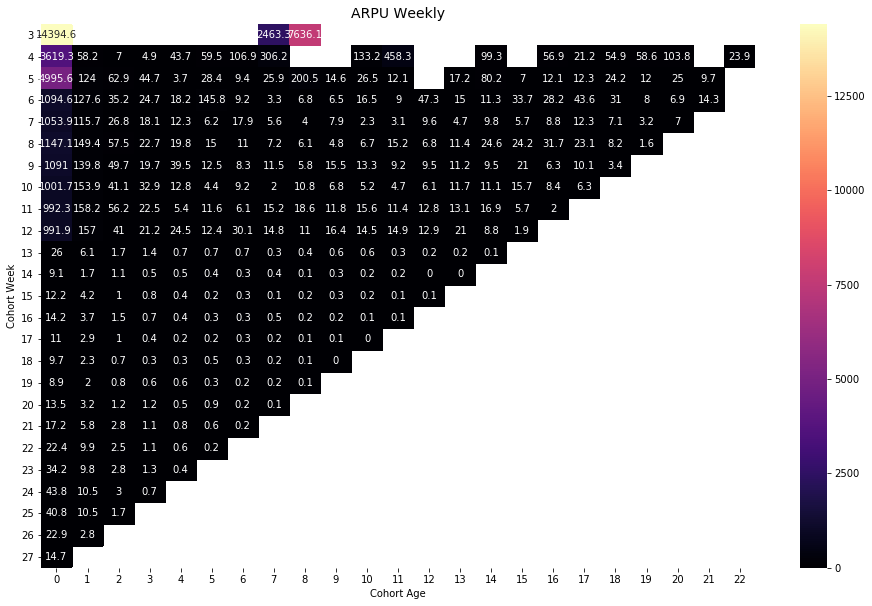

In [35]:
plt.figure(figsize=(16, 10))
plt.title('ARPU Weekly', fontsize = 14)
sns.heatmap(arpu_weekly, annot = True,cmap="magma", fmt='g')
plt.ylabel('Cohort Week')
plt.xlabel('Cohort Age')
plt.yticks(rotation='360')
plt.show()

Что-то сподвигло юзеров из когорты 3 недели вернуться в полном составе через 7 недель, так и еще и кучу денег оставить. Из когорты 4 недели всего 1% пользователей вернулся через 7 недель, но оставил выручку гораздо больше среднего.

## Вывод

Был проведен когортный анализ данных о поведении юзеров в игре. Когорты были поделены по дате первого захода в игру. Были исследованы следующие метрики: Retention и ARPU по месяцам и неделям. В среднем метрики уменьшаются с ходом времени для каждой когорты. Когорты пользователей 3-5 месяцев 2020 года показали большой retention во втором месяце своей жизни, но не принесли повышенной прибыли, значит играли без покупок. В первых недельных когортах интересное поведение: через 7 недель вся первая недельная когорта вернулась и оставила много денег. Во второй недельной когорте только малое количество людей вернулось через 7 недель, но оставило ощутимую выручку.

Из-за ограничения по времени, когортный анализ по дням не был проведен.